<a href="https://colab.research.google.com/github/gorzanskik-ai/computer-vision/blob/main/03_optical_mark_recognition/optical_mark_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/opencv/03_optical_mark_recognition/images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
from google.colab.patches import cv2_imshow
import imutils
from imutils import contours
import numpy as np
import cv2

Intro

In [91]:
ANSWER_KEY = {0: 1, 1: 3, 2: 0, 3: 2, 4: 1, 5: 3, 6: 4, 7: 1, 8: 3, 9: 0}

In [106]:
img = cv2.imread(path + 'answers_1.png')

#gray scale
gray = cv2.cvtColor(img, code=cv2.COLOR_BGR2GRAY)

#blur
gray_blur = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

#edges
edges = cv2.Canny(gray_blur, threshold1=70, threshold2=70)

contours = cv2.findContours(image=edges.copy(), mode=cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'Number of all contours: {len(contours)}')
contours = sorted(contours, key=cv2.contourArea, reverse=True) #sort by contour area

circles = []
for contour in contours:
    perimeter = cv2.arcLength(curve=contour, closed=True)
    #approximation curve of polygon with precision (epsilon)
    approx = cv2.approxPolyDP(curve=contour, epsilon=0.02*perimeter, closed=True)

    #8 points -> rectangle
    if len(approx) == 8:
        circles.append(approx)


circles = sorted(circles, key=cv2.contourArea, reverse=True)
circles = circles[:50]
print(f'Number of circles: {len(circles)}')

Number of all contours: 68
Number of circles: 50


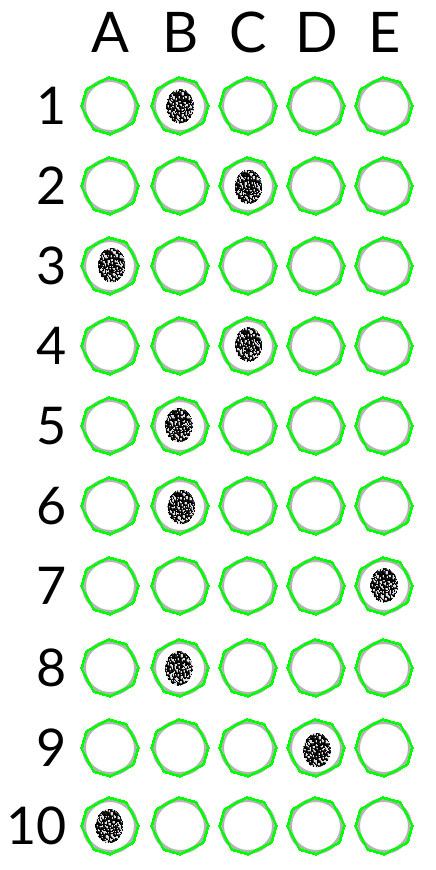

In [107]:
img_cnt = img.copy()
for circle in circles:
    cv2.drawContours(img_cnt, contours=[circle], contourIdx=-1,
                        color=(0, 255, 0), thickness=2)
cv2_imshow(img_cnt)

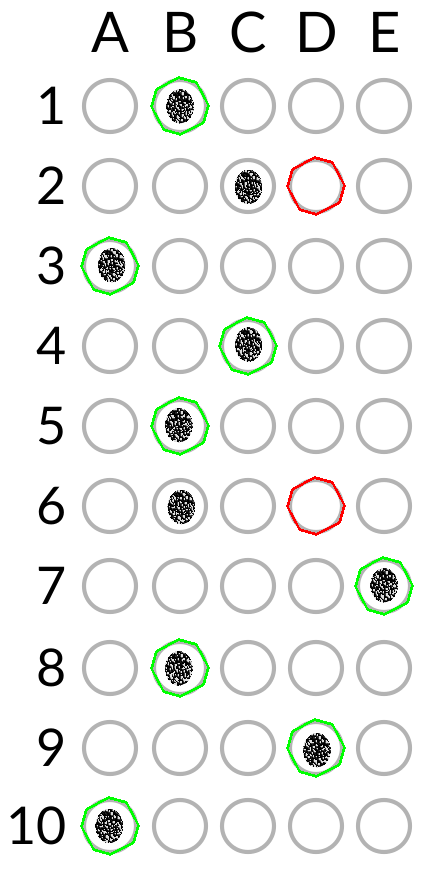

8


In [110]:
top_bottom = imutils.contours.sort_contours(circles, method='top-to-bottom')[0]
sorted_packs_by_5 = [imutils.contours.sort_contours(top_bottom[i: i+5], method='left-to-right')[0] for i in range(0, len(top_bottom), 5)]

correct = 0
for question, pack in enumerate(sorted_packs_by_5):

    marked = None
    for idx, answear in enumerate(pack):

        mask = np.zeros(edges.shape, dtype='uint8')

        # draw contour on mask
        cv2.drawContours(mask, [answear], -1, 255, -1)
        #cv2_imshow(mask)

        # bitwose_and on edges
        mask = cv2.bitwise_and(edges, edges, mask=mask)
        #cv2_imshow(mask)

        # sum of non - zero pixels
        total = cv2.countNonZero(mask)

        #none -> first value, if another total is bigger -> overwrite
        if marked is None or total > marked[0]:
            marked = (total, idx)

    #default - red color
    color = (0, 0, 255)

    key = ANSWER_KEY[question]


    if key == marked[1]:
        # good answear -> green
        color = (0, 255, 0)
        correct += 1

    cv2.drawContours(img, [pack[key]], -1, color, 2)

cv2_imshow(img)
print(correct)

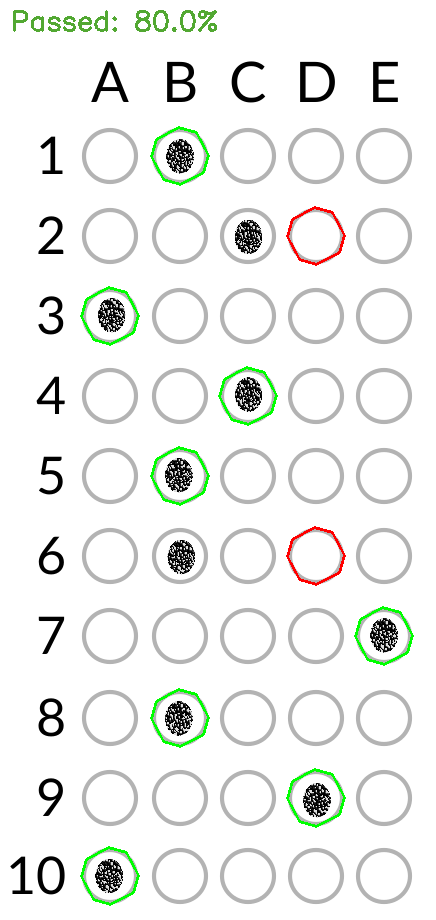

In [111]:
checked = cv2.copyMakeBorder(
    src=img,
    top=50,
    bottom=0,
    left=0,
    right=0,
    borderType=cv2.BORDER_CONSTANT,
    value=(255, 255, 255)
)

score = (correct / 10)

color = (50, 168, 82) if score >= 0.6 else (71, 7, 219)
text = 'Passed' if score >= 0.6 else 'Failed'

cv2.putText(img=checked, text=f'{text}: {score * 100}%', org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.9, color=color, thickness=2)
cv2_imshow(checked)